## Overview

Not all layers in a neural network respond equally to compression. Some layers are robust and can be heavily compressed with minimal impact, while others are fragile and degrade quickly. **Sensitivity analysis** helps you identify which layers fall into each category.

This tutorial shows you how to:
1. Analyze layer sensitivity to different compression methods
2. Identify fragile vs robust layers
3. Generate non-uniform per-layer compression targets based on sensitivity

In [ ]:
#| include: false
import torch
import torch.nn as nn
from torchvision.models import resnet18
from fasterai.analyze.sensitivity import SensitivityAnalyzer, analyze_sensitivity
from fasterai.core.all import large_final

## 1. Setup

First, we need a model and an evaluation function. The evaluation function takes a model and returns a metric (e.g., accuracy, loss).

In [ ]:
# Load a pretrained model
model = resnet18(pretrained=True)
model.eval()

# Create sample input
sample = torch.randn(1, 3, 224, 224)

# Define an evaluation function
# In practice, this would evaluate on your validation set
def eval_fn(m):
    """Simple proxy: measure output magnitude (replace with real accuracy)"""
    with torch.no_grad():
        out = m(sample)
        return out.abs().mean().item()

/home/nathan/miniconda3/envs/dev/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nathan/miniconda3/envs/dev/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 2. Basic Sensitivity Analysis

The simplest way to run sensitivity analysis is with the `analyze_sensitivity()` function:

In [ ]:
result = analyze_sensitivity(
    model, 
    sample, 
    eval_fn,
    compression="sparsity",  # "sparsity", "pruning", or "quantization"
    level=50,                 # 50% sparsity
)

Computing baseline accuracy... 1.1848
Analyzing 21 layers for sparsity @ 50% (granularity=weight, criteria=abs)
  [1/21] conv1... Δ=+0.0064
  [2/21] layer1.0.conv1... Δ=-0.0987
  [3/21] layer1.0.conv2... Δ=-0.0649
  [4/21] layer1.1.conv1... Δ=-0.0779
  [5/21] layer1.1.conv2... Δ=+0.0648
  [6/21] layer2.0.conv1... Δ=-0.1699
  [7/21] layer2.0.conv2... Δ=-0.1183
  [8/21] layer2.0.downsample.0... Δ=-0.2051
  [9/21] layer2.1.conv1... Δ=-0.1259
  [10/21] layer2.1.conv2... Δ=+0.0256
  [11/21] layer3.0.conv1... Δ=-0.0785
  [12/21] layer3.0.conv2... Δ=+0.0398
  [13/21] layer3.0.downsample.0... Δ=-0.0064
  [14/21] layer3.1.conv1... Δ=-0.0353
  [15/21] layer3.1.conv2... Δ=-0.0569
  [16/21] layer4.0.conv1... Δ=-0.0521
  [17/21] layer4.0.conv2... Δ=+0.0452
  [18/21] layer4.0.downsample.0... Δ=+0.0108
  [19/21] layer4.1.conv1... Δ=-0.0230
  [20/21] layer4.1.conv2... Δ=-0.0772
  [21/21] fc... Δ=+0.0573
✓ Analysis complete


## 3. Understanding the Results

The `SensitivityResult` object provides several ways to inspect the results:

In [ ]:
# Print a formatted summary
result.summary()

════════════════════════════════════════════════════════════
Sensitivity Analysis: sparsity @ 50%
════════════════════════════════════════════════════════════
  Baseline accuracy: 1.1848
  Layers analyzed: 21

  🔴 Most Sensitive (fragile):
     1. layer1.1.conv2                 Δ=+0.0648
     2. fc                             Δ=+0.0573
     3. layer4.0.conv2                 Δ=+0.0452
     4. layer3.0.conv2                 Δ=+0.0398
     5. layer2.1.conv2                 Δ=+0.0256

  🟢 Most Robust (compressible):
     1. layer2.0.downsample.0          Δ=-0.2051
     2. layer2.0.conv1                 Δ=-0.1699
     3. layer2.1.conv1                 Δ=-0.1259
     4. layer2.0.conv2                 Δ=-0.1183
     5. layer1.0.conv1                 Δ=-0.0987


In [ ]:
# Get the top 3 most sensitive layers
fragile = result.top(3, most_sensitive=True)
for layer in fragile:
    print(f"{layer.name}: Δ={layer.delta:.4f}")

layer1.1.conv2: Δ=0.0648
fc: Δ=0.0573
layer4.0.conv2: Δ=0.0452


In [ ]:
# Get the top 3 most robust layers (safe to compress heavily)
robust = result.top(3, most_sensitive=False)
for layer in robust:
    print(f"{layer.name}: Δ={layer.delta:.4f}")

layer2.0.downsample.0: Δ=-0.2051
layer2.0.conv1: Δ=-0.1699
layer2.1.conv1: Δ=-0.1259


## 4. Visualizing Sensitivity

A bar chart helps visualize which layers are most sensitive:

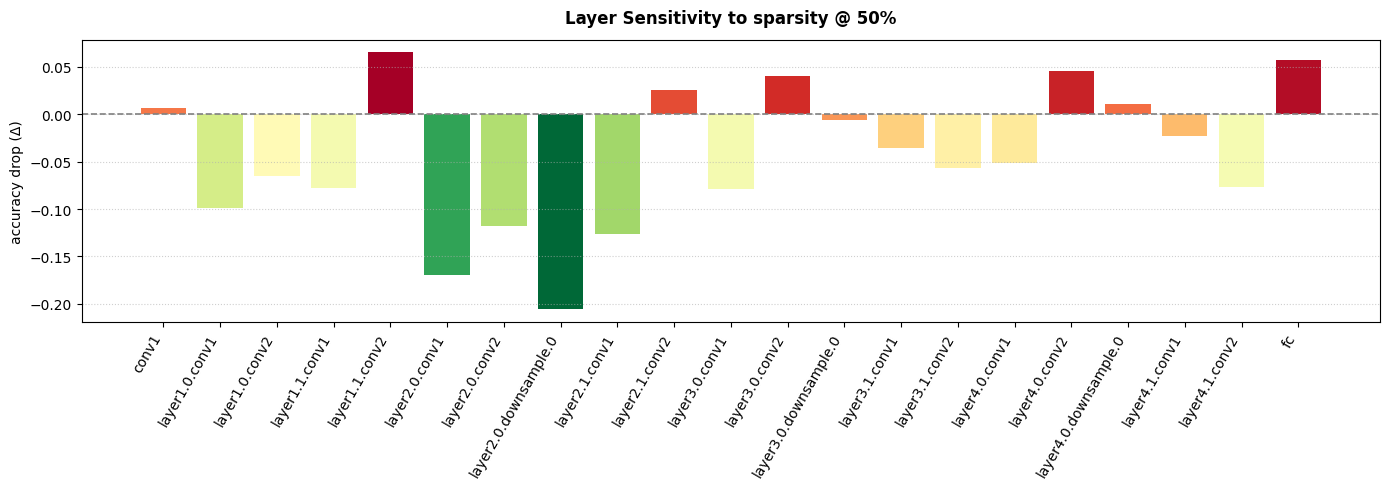

In [ ]:
result.plot(figsize=(14, 5))

## 5. Creating Non-Uniform Per-Layer Targets

The key insight from sensitivity analysis is that you shouldn't compress all layers equally. Use `to_layer_targets()` to generate non-uniform per-layer compression targets:

In [ ]:
targets = result.to_layer_targets(
    model,
    target_pct=50,   # Target 50% average compression
    min_pct=10,      # No layer below 10%
    max_pct=80,      # No layer above 80%
    gamma=1.5,       # Higher = more differentiation between layers
)

# Show a few entries
for name, sparsity in list(targets.items())[:5]:
    print(f"{name}: {sparsity}%")

conv1: 57.59%
layer1.0.conv1: 67.72%
layer1.0.conv2: 67.72%
layer1.1.conv1: 67.72%
layer1.1.conv2: 10.0%


## 6. Applying Per-Layer Targets with Sparsifier

The targets generated by `to_layer_targets()` can be directly used with fasterai's `Sparsifier` to apply non-uniform compression:

In [ ]:
from fasterai.sparse.all import Sparsifier

# 1. Run sensitivity analysis
result = analyze_sensitivity(model, sample, eval_fn, compression="sparsity", level=50)

# 2. Generate per-layer targets (layer_name -> sparsity %)
targets = result.to_layer_targets(model, target_pct=50, min_pct=10, max_pct=80)

# 3. Create a fresh model and Sparsifier
model = resnet18(pretrained=True)
sparsifier = Sparsifier(model, granularity='weight', context='local', criteria=large_final)

# 4. Apply non-uniform sparsity using the targets
for name, module in model.named_modules():
    if name in targets:
        sparsifier.sparsify_layer(module, targets[name])
        
# 5. Check the results
sparsifier.print_sparsity()

Computing baseline accuracy... 1.1848
Analyzing 21 layers for sparsity @ 50% (granularity=weight, criteria=abs)
  [1/21] conv1... Δ=+0.0064
  [2/21] layer1.0.conv1... Δ=-0.0987
  [3/21] layer1.0.conv2... Δ=-0.0649
  [4/21] layer1.1.conv1... Δ=-0.0779
  [5/21] layer1.1.conv2... Δ=+0.0648
  [6/21] layer2.0.conv1... Δ=-0.1699
  [7/21] layer2.0.conv2... Δ=-0.1183
  [8/21] layer2.0.downsample.0... Δ=-0.2051
  [9/21] layer2.1.conv1... Δ=-0.1259
  [10/21] layer2.1.conv2... Δ=+0.0256
  [11/21] layer3.0.conv1... Δ=-0.0785
  [12/21] layer3.0.conv2... Δ=+0.0398
  [13/21] layer3.0.downsample.0... Δ=-0.0064
  [14/21] layer3.1.conv1... Δ=-0.0353
  [15/21] layer3.1.conv2... Δ=-0.0569
  [16/21] layer4.0.conv1... Δ=-0.0521
  [17/21] layer4.0.conv2... Δ=+0.0452
  [18/21] layer4.0.downsample.0... Δ=+0.0108
  [19/21] layer4.1.conv1... Δ=-0.0230
  [20/21] layer4.1.conv2... Δ=-0.0772
  [21/21] fc... Δ=+0.0573
✓ Analysis complete


/home/nathan/miniconda3/envs/dev/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nathan/miniconda3/envs/dev/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Sparsity Report:
--------------------------------------------------------------------------------
Layer                          Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
conv1                          Conv2d          9,408      5,473         58.17%
layer1.0.conv1                 Conv2d          36,864     23,998        65.10%
layer1.0.conv2                 Conv2d          36,864     23,998        65.10%
layer1.1.conv1                 Conv2d          36,864     23,998        65.10%
layer1.1.conv2                 Conv2d          36,864     3,687         10.00%
layer2.0.conv1                 Conv2d          73,728     47,997        65.10%
layer2.0.conv2                 Conv2d          147,456    95,994        65.10%
layer2.0.downsample.0          Conv2d          8,192      5,333         65.10%
layer2.1.conv1                 Conv2d          147,456    95,994        65.10%
layer2.1.conv2               

### Note on Structural Pruning

The `to_layer_targets()` method generates **per-layer compression targets**, which works directly with `Sparsifier`. 

For **structural pruning** with `Pruner`, the current API uses a **uniform ratio** across all layers (torch-pruning handles dependency graphs automatically). You can still use sensitivity analysis to:
1. Identify which layers to **exclude** from pruning (fragile layers)
2. Choose an appropriate **global pruning ratio** based on the most sensitive layers

In [ ]:
from fasterai.prune.all import Pruner

# Use sensitivity to identify layers to EXCLUDE from pruning
fragile_layers = [layer.name for layer in result.top(3, most_sensitive=True)]
print(f"Fragile layers to protect: {fragile_layers}")

# Get the actual module references for ignored_layers
model = resnet18(pretrained=True)
ignored = []
for name, module in model.named_modules():
    if name in fragile_layers:
        ignored.append(module)

# Create Pruner with uniform ratio, but protect fragile layers
pruner = Pruner(
    model,
    example_inputs=sample,
    pruning_ratio=30,           # Uniform 30% pruning
    ignored_layers=ignored,     # Protect sensitive layers!
    context='global',
    criteria=large_final,
)

pruner.prune_model()
pruner.print_sparsity()

Fragile layers to protect: ['layer1.1.conv2', 'fc', 'layer4.0.conv2']

Pruning Report:
-------------------------------------------------------------------------------------
Layer                               Type         In Ch    Out Ch   Params      
-------------------------------------------------------------------------------------
conv1                               Conv2d       3        64       9,408       
layer1.0.conv1                      Conv2d       64       64       36,864      
layer1.0.conv2                      Conv2d       64       64       36,864      
layer1.1.conv1                      Conv2d       64       64       36,864      
layer1.1.conv2                      Conv2d       64       64       36,864      
layer2.0.conv1                      Conv2d       64       128      73,728      
layer2.0.conv2                      Conv2d       128      128      147,456     
layer2.0.downsample.0               Conv2d       64       128      8,192       
layer2.1.conv1       

> **Workflow Summary**:
> - **Sparsifier**: Use `to_layer_targets()` for per-layer sparsity targets
> - **Pruner**: Use `top(most_sensitive=True)` to identify layers to protect via `ignored_layers`
> - **Both**: Fine-tune after compression to recover accuracy

## 7. Using SensitivityAnalyzer for More Control

In [ ]:
analyzer = SensitivityAnalyzer(
    model,
    sample,
    eval_fn,
    criteria=large_final,       # Importance scoring method
    higher_is_better=True,      # Higher metric = better
    metric_name="accuracy",     # For display
)

# Analyze sparsity sensitivity
sparsity_result = analyzer.analyze(
    compression="sparsity",
    level=50,
    granularity="weight",  # or "filter", "kernel", etc.
)

Computing baseline accuracy... 0.6909
Analyzing 21 layers for sparsity @ 50% (granularity=weight, criteria=abs)
  [1/21] conv1... Δ=+0.0001
  [2/21] layer1.0.conv1... Δ=-0.0006
  [3/21] layer1.0.conv2... Δ=-0.0046
  [4/21] layer1.1.conv1... Δ=-0.0052
  [5/21] layer1.1.conv2... Δ=+0.0020
  [6/21] layer2.0.conv1... Δ=-0.0021
  [7/21] layer2.0.conv2... Δ=-0.0031
  [8/21] layer2.0.downsample.0... Δ=-0.0055
  [9/21] layer2.1.conv1... Δ=-0.0014
  [10/21] layer2.1.conv2... Δ=-0.0021
  [11/21] layer3.0.conv1... Δ=+0.0017
  [12/21] layer3.0.conv2... Δ=+0.0051
  [13/21] layer3.0.downsample.0... Δ=+0.0010
  [14/21] layer3.1.conv1... Δ=+0.0031
  [15/21] layer3.1.conv2... Δ=+0.0005
  [16/21] layer4.0.conv1... Δ=+0.0053
  [17/21] layer4.0.conv2... Δ=-0.0020
  [18/21] layer4.0.downsample.0... Δ=-0.0050
  [19/21] layer4.1.conv1... Δ=+0.0036
  [20/21] layer4.1.conv2... Δ=-0.0001
  [21/21] fc... Δ=-0.5034
✓ Analysis complete


## 8. Different Compression Types

In [ ]:
sparsity_result = analyzer.analyze(
    compression="sparsity",
    level=50,                # 50% of weights zeroed
    granularity="weight",    # Unstructured sparsity
)

Computing baseline accuracy... 0.6909
Analyzing 21 layers for sparsity @ 50% (granularity=weight, criteria=abs)
  [1/21] conv1... Δ=+0.0001
  [2/21] layer1.0.conv1... Δ=-0.0006
  [3/21] layer1.0.conv2... Δ=-0.0046
  [4/21] layer1.1.conv1... Δ=-0.0052
  [5/21] layer1.1.conv2... Δ=+0.0020
  [6/21] layer2.0.conv1... Δ=-0.0021
  [7/21] layer2.0.conv2... Δ=-0.0031
  [8/21] layer2.0.downsample.0... Δ=-0.0055
  [9/21] layer2.1.conv1... Δ=-0.0014
  [10/21] layer2.1.conv2... Δ=-0.0021
  [11/21] layer3.0.conv1... Δ=+0.0017
  [12/21] layer3.0.conv2... Δ=+0.0051
  [13/21] layer3.0.downsample.0... Δ=+0.0010
  [14/21] layer3.1.conv1... Δ=+0.0031
  [15/21] layer3.1.conv2... Δ=+0.0005
  [16/21] layer4.0.conv1... Δ=+0.0053
  [17/21] layer4.0.conv2... Δ=-0.0020
  [18/21] layer4.0.downsample.0... Δ=-0.0050
  [19/21] layer4.1.conv1... Δ=+0.0036
  [20/21] layer4.1.conv2... Δ=-0.0001
  [21/21] fc... Δ=-0.5034
✓ Analysis complete


### Structural Pruning (Filter Removal)

In [ ]:
pruning_result = analyzer.analyze(
    compression="pruning",
    level=30,                # 30% of filters removed
)

Computing baseline accuracy... 0.6909
Analyzing 21 layers for pruning @ 30% (structural, criteria=abs)
  [1/21] conv1... Δ=0.0000
  [2/21] layer1.0.conv1... Δ=-0.0016
  [3/21] layer1.0.conv2... Δ=0.0000
  [4/21] layer1.1.conv1... Δ=-0.0001
  [5/21] layer1.1.conv2... Δ=0.0000
  [6/21] layer2.0.conv1... Δ=-0.0045
  [7/21] layer2.0.conv2... Δ=0.0000
  [8/21] layer2.0.downsample.0... Δ=0.0000
  [9/21] layer2.1.conv1... Δ=-0.0187
  [10/21] layer2.1.conv2... Δ=0.0000
  [11/21] layer3.0.conv1... Δ=+0.0001
  [12/21] layer3.0.conv2... Δ=0.0000
  [13/21] layer3.0.downsample.0... Δ=0.0000
  [14/21] layer3.1.conv1... Δ=-0.0012
  [15/21] layer3.1.conv2... Δ=0.0000
  [16/21] layer4.0.conv1... Δ=-0.0063
  [17/21] layer4.0.conv2... Δ=0.0000
  [18/21] layer4.0.downsample.0... Δ=0.0000
  [19/21] layer4.1.conv1... Δ=0.0000
  [20/21] layer4.1.conv2... Δ=0.0000
  [21/21] fc... Δ=+0.0301
✓ Analysis complete


### Quantization (Precision Reduction)

In [ ]:
quant_result = analyzer.analyze(
    compression="quantization",
    level=8,                     # 8-bit quantization
    quant_per_channel=True,      # Per-channel quantization
    quant_activations=False,     # Weights only
)

Computing baseline accuracy... 0.6909
Analyzing 21 layers for quantization @ 8bits (per-channel, weights only)
  [1/21] conv1... Δ=-0.0002
  [2/21] layer1.0.conv1... Δ=+0.0003
  [3/21] layer1.0.conv2... Δ=+0.0001
  [4/21] layer1.1.conv1... Δ=-0.0002
  [5/21] layer1.1.conv2... Δ=-0.0003
  [6/21] layer2.0.conv1... Δ=-0.0001
  [7/21] layer2.0.conv2... Δ=-0.0002
  [8/21] layer2.0.downsample.0... Δ=-0.0002
  [9/21] layer2.1.conv1... Δ=-0.0004
  [10/21] layer2.1.conv2... Δ=-0.0000
  [11/21] layer3.0.conv1... Δ=+0.0000
  [12/21] layer3.0.conv2... Δ=+0.0001
  [13/21] layer3.0.downsample.0... Δ=-0.0000
  [14/21] layer3.1.conv1... Δ=-0.0001
  [15/21] layer3.1.conv2... Δ=+0.0002
  [16/21] layer4.0.conv1... Δ=-0.0002
  [17/21] layer4.0.conv2... Δ=-0.0000
  [18/21] layer4.0.downsample.0... Δ=-0.0002
  [19/21] layer4.1.conv1... Δ=+0.0001
  [20/21] layer4.1.conv2... Δ=+0.0000
  [21/21] fc... Δ=-0.0009
✓ Analysis complete


## 9. Sweeping Multiple Compression Levels

In [ ]:
results = analyzer.sweep(
    compression="sparsity",
    levels=[25, 50, 75],
)


Sweep: sparsity @ 25%
Computing baseline accuracy... 0.6909
Analyzing 21 layers for sparsity @ 25% (granularity=weight, criteria=abs)
  [1/21] conv1... Δ=-0.0001
  [2/21] layer1.0.conv1... Δ=-0.0003
  [3/21] layer1.0.conv2... Δ=+0.0005
  [4/21] layer1.1.conv1... Δ=-0.0006
  [5/21] layer1.1.conv2... Δ=+0.0015
  [6/21] layer2.0.conv1... Δ=+0.0010
  [7/21] layer2.0.conv2... Δ=+0.0019
  [8/21] layer2.0.downsample.0... Δ=-0.0014
  [9/21] layer2.1.conv1... Δ=+0.0009
  [10/21] layer2.1.conv2... Δ=+0.0000
  [11/21] layer3.0.conv1... Δ=-0.0012
  [12/21] layer3.0.conv2... Δ=+0.0007
  [13/21] layer3.0.downsample.0... Δ=+0.0008
  [14/21] layer3.1.conv1... Δ=+0.0004
  [15/21] layer3.1.conv2... Δ=-0.0005
  [16/21] layer4.0.conv1... Δ=+0.0010
  [17/21] layer4.0.conv2... Δ=-0.0006
  [18/21] layer4.0.downsample.0... Δ=-0.0011
  [19/21] layer4.1.conv1... Δ=+0.0011
  [20/21] layer4.1.conv2... Δ=-0.0000
  [21/21] fc... Δ=-0.0011
✓ Analysis complete

Sweep: sparsity @ 50%
Computing baseline accuracy... 0.

## 10. Exporting Results

In [ ]:
df = result.to_dataframe()
df.head()

,name,layer_type,params,baseline_metric,compressed_metric,delta
0,conv1,Conv2d,9408,1.184846,1.178427,0.006419
1,layer1.0.conv1,Conv2d,36864,1.184846,1.283498,-0.098653
2,layer1.0.conv2,Conv2d,36864,1.184846,1.249760,-0.064914
3,layer1.1.conv1,Conv2d,36864,1.184846,1.262704,-0.077859
4,layer1.1.conv2,Conv2d,36864,1.184846,1.120000,0.064846


---

## Summary

| Function/Method | Purpose |
|-----------------|--------|
| `analyze_sensitivity()` | One-line sensitivity analysis |
| `SensitivityAnalyzer` | Full control over analysis |
| `result.summary()` | Print formatted summary |
| `result.top(n, most_sensitive)` | Get top N layers |
| `result.plot()` | Visualize sensitivity |
| `result.to_layer_targets()` | Generate non-uniform per-layer compression targets |
| `result.to_dataframe()` | Export to pandas |
| `analyzer.sweep()` | Test multiple compression levels |

---

## See Also

- [Sparsifier](../sparse/sparsifier.html) - Apply sparsity to models
- [Pruner](../../prune/pruner.html) - Structural pruning
- [Criteria](../../core/criteria.html) - Importance scoring methods
- [Schedules](../../core/schedules.html) - Gradual compression schedules